<a href="https://www.kaggle.com/code/rohan843/podcast-time-prediction?scriptVersionId=244412530" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gc

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")
train.columns

Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes'],
      dtype='object')

In [4]:
# Can treat this as one hot later
train['Publication_Time'].unique()

array(['Night', 'Afternoon', 'Evening', 'Morning'], dtype=object)

In [5]:
# See graph to figure out how to work with null values

train['Guest_Popularity_percentage'].mean()

52.23644893379307

In [6]:
# Make all 103. ...'s as 103
train['Number_of_Ads'].unique()

array([  0.  ,   2.  ,   3.  ,   1.  ,  53.37,    nan, 103.91, 103.  ,
        53.42, 103.75,  12.  , 103.25, 103.88])

In [7]:
# Can make all large numbers (>12) to be `large`

train['Number_of_Ads'].value_counts().sort_index()

Number_of_Ads
0.00      217592
1.00      214069
2.00      158156
3.00      160173
12.00          1
53.37          1
53.42          1
103.00         1
103.25         2
103.75         1
103.88         1
103.91         1
Name: count, dtype: int64

In [8]:
train['deriv_Number_of_Ads'] = train['Number_of_Ads'].apply(lambda x: x if x < 4 else 10)
train['deriv_Number_of_Ads'].value_counts().sort_index()

deriv_Number_of_Ads
0.0     217592
1.0     214069
2.0     158156
3.0     160173
10.0        10
Name: count, dtype: int64

In [9]:
# Can treat this as numeric (1, 2, 3)
train['Episode_Sentiment'].unique()

array(['Positive', 'Negative', 'Neutral'], dtype=object)

In [10]:
train['deriv_Episode_Sentiment'] = train['Episode_Sentiment'].apply(lambda x: 3 if x == 'Positive' else 1 if x == 'Negative' else 2)
train['deriv_Episode_Sentiment'].value_counts().sort_index()

deriv_Episode_Sentiment
1    250116
2    251291
3    248593
Name: count, dtype: int64

In [11]:
# Final output
train['Listening_Time_minutes']

0          31.41998
1          88.01241
2          44.92531
3          46.27824
4          75.61031
            ...    
749995     56.87058
749996     45.46242
749997     15.26000
749998    100.72939
749999     11.94439
Name: Listening_Time_minutes, Length: 750000, dtype: float64

In [12]:
train['deriv_Episode_Length_minutes'] = train['Episode_Length_minutes'].fillna(
    train.groupby('Podcast_Name')['Episode_Length_minutes'].transform('mean')
)

In [13]:
train

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,deriv_Number_of_Ads,deriv_Episode_Sentiment,deriv_Episode_Length_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,0.0,3,64.388461
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,2.0,1,119.800000
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,0.0,1,73.900000
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,2.0,3,67.170000
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,3.0,2,110.510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058,0.0,1,75.660000
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242,2.0,2,75.750000
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000,0.0,1,30.980000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939,0.0,1,108.980000


In [14]:
train['deriv_Episode_Title'] = train['Episode_Title'].apply(lambda x: int(x[8:]))
train['deriv_Episode_Title']

0         98
1         26
2         16
3         45
4         86
          ..
749995    25
749996    21
749997    51
749998    47
749999    99
Name: deriv_Episode_Title, Length: 750000, dtype: int64

In [15]:
train.to_csv('train.csv')

In [16]:
train

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,deriv_Number_of_Ads,deriv_Episode_Sentiment,deriv_Episode_Length_minutes,deriv_Episode_Title
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,0.0,3,64.388461,98
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,2.0,1,119.800000,26
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,0.0,1,73.900000,16
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,2.0,3,67.170000,45
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,3.0,2,110.510000,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058,0.0,1,75.660000,25
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242,2.0,2,75.750000,21
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000,0.0,1,30.980000,51
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939,0.0,1,108.980000,47


In [17]:
train["deriv_Guest_Popularity_percentage"] = train["Guest_Popularity_percentage"].fillna(0)

In [18]:
train.isna().sum()

id                                        0
Podcast_Name                              0
Episode_Title                             0
Episode_Length_minutes                87093
Genre                                     0
Host_Popularity_percentage                0
Publication_Day                           0
Publication_Time                          0
Guest_Popularity_percentage          146030
Number_of_Ads                             1
Episode_Sentiment                         0
Listening_Time_minutes                    0
deriv_Number_of_Ads                       0
deriv_Episode_Sentiment                   0
deriv_Episode_Length_minutes              0
deriv_Episode_Title                       0
deriv_Guest_Popularity_percentage         0
dtype: int64

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 17 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 750000 non-null  int64  
 1   Podcast_Name                       750000 non-null  object 
 2   Episode_Title                      750000 non-null  object 
 3   Episode_Length_minutes             662907 non-null  float64
 4   Genre                              750000 non-null  object 
 5   Host_Popularity_percentage         750000 non-null  float64
 6   Publication_Day                    750000 non-null  object 
 7   Publication_Time                   750000 non-null  object 
 8   Guest_Popularity_percentage        603970 non-null  float64
 9   Number_of_Ads                      749999 non-null  float64
 10  Episode_Sentiment                  750000 non-null  object 
 11  Listening_Time_minutes             7500

In [20]:
df = train[["Podcast_Name", "deriv_Episode_Title", "deriv_Episode_Length_minutes", 
            "Genre", "Host_Popularity_percentage", "Publication_Day", "Publication_Time",
            "deriv_Guest_Popularity_percentage", "deriv_Number_of_Ads", "deriv_Episode_Sentiment",
            "Listening_Time_minutes"
           ]].copy(deep=True)

In [21]:
days = set(df["Publication_Day"])
time = set(df["Publication_Time"])

averages = dict()

for d in days:
    for t in time:
        averages[f"{d}_{t}"] = df[(df["Publication_Day"] == d) & (df["Publication_Time"] == t)]["Listening_Time_minutes"].mean()

df["deriv_Avg_Listening_Time_On_Same_Time_of_Day"] = df.apply(lambda row: averages[f"{row['Publication_Day']}_{row['Publication_Time']}"], axis = 1)
df

,Podcast_Name,deriv_Episode_Title,deriv_Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,deriv_Guest_Popularity_percentage,deriv_Number_of_Ads,deriv_Episode_Sentiment,Listening_Time_minutes,deriv_Avg_Listening_Time_On_Same_Time_of_Day
0,Mystery Matters,98,64.388461,True Crime,74.81,Thursday,Night,0.00,0.0,3,31.41998,45.625729
1,Joke Junction,26,119.800000,Comedy,66.95,Saturday,Afternoon,75.95,2.0,1,88.01241,45.556705
2,Study Sessions,16,73.900000,Education,69.97,Tuesday,Evening,8.97,0.0,1,44.92531,45.685454
3,Digital Digest,45,67.170000,Technology,57.22,Monday,Morning,78.70,2.0,3,46.27824,45.577423
4,Mind & Body,86,110.510000,Health,80.07,Monday,Afternoon,58.68,3.0,2,75.61031,46.397311
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,Learning Lab,25,75.660000,Education,69.36,Saturday,Morning,0.00,0.0,1,56.87058,44.927321
749996,Business Briefs,21,75.750000,Business,35.21,Saturday,Night,0.00,2.0,2,45.46242,46.087074
749997,Lifestyle Lounge,51,30.980000,Lifestyle,78.58,Thursday,Morning,84.89,0.0,1,15.26000,44.426158
749998,Style Guide,47,108.980000,Lifestyle,45.39,Thursday,Morning,93.27,0.0,1,100.72939,44.426158


In [22]:
df = df.drop(["Publication_Day", "Publication_Time"], axis=1)
df

,Podcast_Name,deriv_Episode_Title,deriv_Episode_Length_minutes,Genre,Host_Popularity_percentage,deriv_Guest_Popularity_percentage,deriv_Number_of_Ads,deriv_Episode_Sentiment,Listening_Time_minutes,deriv_Avg_Listening_Time_On_Same_Time_of_Day
0,Mystery Matters,98,64.388461,True Crime,74.81,0.00,0.0,3,31.41998,45.625729
1,Joke Junction,26,119.800000,Comedy,66.95,75.95,2.0,1,88.01241,45.556705
2,Study Sessions,16,73.900000,Education,69.97,8.97,0.0,1,44.92531,45.685454
3,Digital Digest,45,67.170000,Technology,57.22,78.70,2.0,3,46.27824,45.577423
4,Mind & Body,86,110.510000,Health,80.07,58.68,3.0,2,75.61031,46.397311
...,...,...,...,...,...,...,...,...,...,...
749995,Learning Lab,25,75.660000,Education,69.36,0.00,0.0,1,56.87058,44.927321
749996,Business Briefs,21,75.750000,Business,35.21,0.00,2.0,2,45.46242,46.087074
749997,Lifestyle Lounge,51,30.980000,Lifestyle,78.58,84.89,0.0,1,15.26000,44.426158
749998,Style Guide,47,108.980000,Lifestyle,45.39,93.27,0.0,1,100.72939,44.426158


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   Podcast_Name                                  750000 non-null  object 
 1   deriv_Episode_Title                           750000 non-null  int64  
 2   deriv_Episode_Length_minutes                  750000 non-null  float64
 3   Genre                                         750000 non-null  object 
 4   Host_Popularity_percentage                    750000 non-null  float64
 5   deriv_Guest_Popularity_percentage             750000 non-null  float64
 6   deriv_Number_of_Ads                           750000 non-null  float64
 7   deriv_Episode_Sentiment                       750000 non-null  int64  
 8   Listening_Time_minutes                        750000 non-null  float64
 9   deriv_Avg_Listening_Time_On_Same_Time_of_Day  75

In [24]:
df = pd.get_dummies(df, columns=["Genre"], dtype=int).drop(["Genre_Education"], axis = 1)

In [25]:
df

,Podcast_Name,deriv_Episode_Title,deriv_Episode_Length_minutes,Host_Popularity_percentage,deriv_Guest_Popularity_percentage,deriv_Number_of_Ads,deriv_Episode_Sentiment,Listening_Time_minutes,deriv_Avg_Listening_Time_On_Same_Time_of_Day,Genre_Business,Genre_Comedy,Genre_Health,Genre_Lifestyle,Genre_Music,Genre_News,Genre_Sports,Genre_Technology,Genre_True Crime
0,Mystery Matters,98,64.388461,74.81,0.00,0.0,3,31.41998,45.625729,0,0,0,0,0,0,0,0,1
1,Joke Junction,26,119.800000,66.95,75.95,2.0,1,88.01241,45.556705,0,1,0,0,0,0,0,0,0
2,Study Sessions,16,73.900000,69.97,8.97,0.0,1,44.92531,45.685454,0,0,0,0,0,0,0,0,0
3,Digital Digest,45,67.170000,57.22,78.70,2.0,3,46.27824,45.577423,0,0,0,0,0,0,0,1,0
4,Mind & Body,86,110.510000,80.07,58.68,3.0,2,75.61031,46.397311,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,Learning Lab,25,75.660000,69.36,0.00,0.0,1,56.87058,44.927321,0,0,0,0,0,0,0,0,0
749996,Business Briefs,21,75.750000,35.21,0.00,2.0,2,45.46242,46.087074,1,0,0,0,0,0,0,0,0
749997,Lifestyle Lounge,51,30.980000,78.58,84.89,0.0,1,15.26000,44.426158,0,0,0,1,0,0,0,0,0
749998,Style Guide,47,108.980000,45.39,93.27,0.0,1,100.72939,44.426158,0,0,0,1,0,0,0,0,0


In [26]:
df = df.drop(['Podcast_Name', 'deriv_Episode_Title'], axis = 1)
df

,deriv_Episode_Length_minutes,Host_Popularity_percentage,deriv_Guest_Popularity_percentage,deriv_Number_of_Ads,deriv_Episode_Sentiment,Listening_Time_minutes,deriv_Avg_Listening_Time_On_Same_Time_of_Day,Genre_Business,Genre_Comedy,Genre_Health,Genre_Lifestyle,Genre_Music,Genre_News,Genre_Sports,Genre_Technology,Genre_True Crime
0,64.388461,74.81,0.00,0.0,3,31.41998,45.625729,0,0,0,0,0,0,0,0,1
1,119.800000,66.95,75.95,2.0,1,88.01241,45.556705,0,1,0,0,0,0,0,0,0
2,73.900000,69.97,8.97,0.0,1,44.92531,45.685454,0,0,0,0,0,0,0,0,0
3,67.170000,57.22,78.70,2.0,3,46.27824,45.577423,0,0,0,0,0,0,0,1,0
4,110.510000,80.07,58.68,3.0,2,75.61031,46.397311,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,75.660000,69.36,0.00,0.0,1,56.87058,44.927321,0,0,0,0,0,0,0,0,0
749996,75.750000,35.21,0.00,2.0,2,45.46242,46.087074,1,0,0,0,0,0,0,0,0
749997,30.980000,78.58,84.89,0.0,1,15.26000,44.426158,0,0,0,1,0,0,0,0,0
749998,108.980000,45.39,93.27,0.0,1,100.72939,44.426158,0,0,0,1,0,0,0,0,0


In [27]:
in_cols = ['deriv_Episode_Sentiment',
 'Genre_News',
 'deriv_Episode_Length_minutes',
 'deriv_Number_of_Ads',
 'Genre_Comedy',
 'Genre_Music',
 'Genre_Lifestyle',
 'Genre_Technology',
 'Genre_Business',
 'Host_Popularity_percentage',
 'deriv_Guest_Popularity_percentage',
 'Genre_Health',
 'deriv_Avg_Listening_Time_On_Same_Time_of_Day',
 'Genre_True Crime',
 'Genre_Sports']
out_col = 'Listening_Time_minutes'

X = df[in_cols].values
y = df[out_col].values

In [28]:
df = df[in_cols + [out_col]]
df

,deriv_Episode_Sentiment,Genre_News,deriv_Episode_Length_minutes,deriv_Number_of_Ads,Genre_Comedy,Genre_Music,Genre_Lifestyle,Genre_Technology,Genre_Business,Host_Popularity_percentage,deriv_Guest_Popularity_percentage,Genre_Health,deriv_Avg_Listening_Time_On_Same_Time_of_Day,Genre_True Crime,Genre_Sports,Listening_Time_minutes
0,3,0,64.388461,0.0,0,0,0,0,0,74.81,0.00,0,45.625729,1,0,31.41998
1,1,0,119.800000,2.0,1,0,0,0,0,66.95,75.95,0,45.556705,0,0,88.01241
2,1,0,73.900000,0.0,0,0,0,0,0,69.97,8.97,0,45.685454,0,0,44.92531
3,3,0,67.170000,2.0,0,0,0,1,0,57.22,78.70,0,45.577423,0,0,46.27824
4,2,0,110.510000,3.0,0,0,0,0,0,80.07,58.68,1,46.397311,0,0,75.61031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,1,0,75.660000,0.0,0,0,0,0,0,69.36,0.00,0,44.927321,0,0,56.87058
749996,2,0,75.750000,2.0,0,0,0,0,1,35.21,0.00,0,46.087074,0,0,45.46242
749997,1,0,30.980000,0.0,0,0,1,0,0,78.58,84.89,0,44.426158,0,0,15.26000
749998,1,0,108.980000,0.0,0,0,1,0,0,45.39,93.27,0,44.426158,0,0,100.72939


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
X_train.shape

(600000, 15)

In [32]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE:", root_mean_squared_error(y_test, y_pred))

RMSE: 13.320188405169086


In [33]:
y_pred = model.predict(X_train)

print("RMSE:", root_mean_squared_error(y_pred, y_train))

RMSE: 13.371039480006786


In [34]:
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_train)

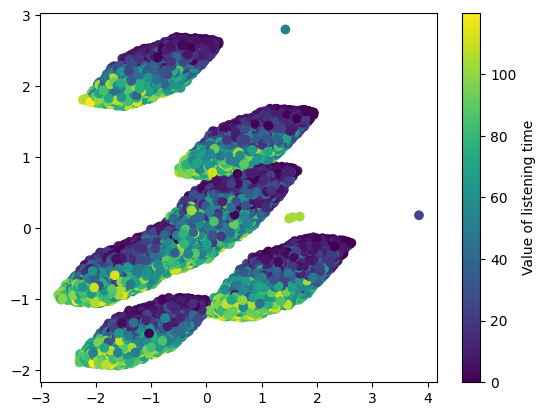

In [35]:
plt.scatter(X_pca[:,0], X_pca[:,4], c = y_train, cmap='viridis')
plt.colorbar(label='Value of listening time')

In [36]:
print(pca.singular_values_)

[825.63195882 824.35992463 822.98605182 822.10873747 821.4775421
 816.36240918 815.03229778 811.37227855 801.18311081 775.81915691
 774.13721912 768.44066913 764.87096619 747.89515061 209.19899832]


In [37]:
model = DecisionTreeRegressor(random_state=0, max_depth=9)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE:", root_mean_squared_error(y_test, y_pred))

RMSE: 13.155377959045746


In [38]:
# #max_depth = 9 :: RMSE = 13.122988529321258
# #max_depth = 13 :: RMSE = 13.019193381838358
# model = RandomForestRegressor(random_state=0, max_depth=13)

# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# print("RMSE:", root_mean_squared_error(y_test, y_pred))

In [39]:
# model = RandomForestRegressor(random_state=0, max_depth=13)

# model.fit(X_train, y_train)
# y_pred = model.predict(X_train)

# print("RMSE:", root_mean_squared_error(y_train, y_pred))

In [40]:
min_so_far_max_depth = None
min_so_far_n_estimators = None
min_so_far_rmse = 40

for n_estimator in range(50,301,50):
    for max_depth in range(2,20):
        model = RandomForestRegressor(random_state=0, max_depth=max_depth, n_estimators=n_estimator)
        print(f"max_depth:{max_depth} n_estimators: {n_estimator}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)  
        if rmse < min_so_far_rmse:
            min_so_far_rmse = rmse
            min_so_far_max_depth = max_depth
            min_so_far_n_estimators = n_estimator
        print("RMSE:", rmse)
        gc.collect()

max_depth:2 n_estimators: 50
RMSE: 14.78968617357023
max_depth:3 n_estimators: 50
RMSE: 13.769329865300461
max_depth:4 n_estimators: 50
RMSE: 13.478493998627519
max_depth:5 n_estimators: 50
RMSE: 13.313398762347767
max_depth:6 n_estimators: 50
RMSE: 13.221695265442127
max_depth:7 n_estimators: 50
RMSE: 13.1772683999603
max_depth:8 n_estimators: 50
RMSE: 13.147499114874787
max_depth:9 n_estimators: 50
RMSE: 13.123597397251023
max_depth:10 n_estimators: 50
RMSE: 13.10033964487346
max_depth:11 n_estimators: 50
RMSE: 13.076260617452544
max_depth:12 n_estimators: 50
RMSE: 13.051118116166682
max_depth:13 n_estimators: 50
RMSE: 13.024202942519125
max_depth:14 n_estimators: 50
RMSE: 12.996171264700763
max_depth:15 n_estimators: 50
RMSE: 12.971163282807103
max_depth:16 n_estimators: 50
RMSE: 12.946462446866358
max_depth:17 n_estimators: 50
RMSE: 12.923969490569267
max_depth:18 n_estimators: 50
RMSE: 12.900751323155747
max_depth:19 n_estimators: 50
RMSE: 12.885326349348276
max_depth:2 n_estimato